<a href="https://colab.research.google.com/github/dtminnick/pytorch-practice/blob/main/dl_assignment1_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Deep Learning - Manually Graded Assignment 1 - Part 2 (CIFAR Dataset)**

Donnie Minnick

October 2025

# Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Load CIFAR Data

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Get training data.

training_data = torchvision.datasets.CIFAR10(root = './data',
                                             train = True,
                                             download = True,
                                             transform = transform)

# Get testing data.

testing_data = torchvision.datasets.CIFAR10(root = './data',
                                            train = False,
                                            download = True,
                                            transform = transform)


Confirm download of training data.

In [ ]:
print("Training set size:", len(training_data))

Training set size: 50000


Confirm download of testing data.

In [ ]:
print("Testing set size:", len(testing_data))

Testing set size: 10000


# Split Data

Split the data into training, validation and testing sets.

A testing set already exists; randomly take 10,000 images from the training set and reserve them as a validation set.

In [ ]:
train_size = 40000
val_size = 10000

training_data, validation_data = random_split(training_data, [train_size, val_size])

Confirm splits.

In [ ]:
print("Training set size:", len(training_data))
print("Validation set size:", len(validation_data))
print("Testing set size:", len(testing_data))

Training set size: 40000
Validation set size: 10000
Testing set size: 10000


# Build a CNN Network

Build a CNN network with convolution layers to classify the images.

# Implement Sweep Strategy

Implement a sweep strategy to find the optimal hyperparameters to maximize accuracy.

Systematically vary key hyperparameters - kernel size, stride, batch size, and learning rate - to assess their impact on training loss, validation accuracy, and feature map evolution.  This modular sweep enables principled experimentation, helping identify optimal architecture and training settings for improved model performance and stakeholder clarity.

## Create Sweep Grid

Create a sweep grid to explore four key hyperparameters that influence CNN performance.

In [ ]:
sweep_grid = {'kernel_size': [3],
              'stride': [2],
              'batch_size': [16],
              'learning_rate': [0.001]}

**Kernel size** [3, 5] tests the impact of local versus broader spatial feature extraction.

**Stride** [1, 2] assesses how spatial resolution and downsizing effect learning.

**Batch size** [32, 64] evaluates gradient stability, generalization, and training efficiency.

**Learning rate** [0.001, 0.01] measures convergence speed and sensitivity to weight updates.

This grid yields 16 unique configurations (2 * 2 * 2 * 2), each to be trained and evaluated to compare loss, accuracy, and feature map evolution.

The goal is to identify the optimal combinations for model performance.

## Compute Flattened Size Function

Function to compute the current input size for the model.  Use input shape 32 * 32 with three channels.

In [ ]:
def compute_flattened_size(model, input_shape = (3, 32, 32)):
  with torch.no_grad():
    dummy = torch.zeros(1, *input_shape)
    output = model(dummy)
    return output.view(1, -1).shape[1]

## Create Model Builder

Implement modular construction of a CNN with the specified kernel size and stride.

In [ ]:
def build_model(kernel_size, stride):
  feature_extractor = nn.Sequential(
      nn.Conv2d(3, 6, kernel_size = kernel_size, stride = stride),
      nn.ReLU(),
      nn.Conv2d(6, 16, kernel_size = kernel_size, stride = stride),
      nn.ReLU(),
      nn.Flatten()
  )

  flattened_size = compute_flattened_size(feature_extractor)

  return nn.Sequential(
      feature_extractor,
      nn.Linear(flattened_size, 10),
      nn.Softmax(dim = 1)
  )

## Create DataLoader Factory

Create data loaders with consistent batching to keep data handling clean and configurable.

In [ ]:
def create_dataloaders(training_data, validation_data, testing_data, batch_size):
  training_loader = DataLoader(training_data, batch_size = batch_size, shuffle = True)
  validation_loader = DataLoader(validation_data, batch_size = batch_size, shuffle = False)
  testing_loader = DataLoader(testing_data, batch_size = batch_size, shuffle = False)
  return training_loader, validation_loader, testing_loader

## Create Train Model Function

Function to train the model and return final loss and validation accuracy; modular design for reuse across sweeps.

In [ ]:
def train_model(model, training_loader, validation_loader, lr, device = "cpu", epochs = 10):
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr = lr)
  criterion = nn.NLLLoss()

  for epoch in range(epochs):
    model.train()
    for images, labels in training_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      output = model(images)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()

  model.eval()
  correct, total = 0, 0

  with torch.no_grad():
    for images, labels in validation_loader:
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      pred = output.argmax(dim = 1)
      correct += (pred == labels).sum().item()
      total += labels.size(0)

  val_accuracy = 100 * correct / total
  return loss.item(), val_accuracy

In [ ]:
def train_model(model, train_loader, val_loader, learning_rate, epochs=50):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss_log = []
    val_acc_log = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_loss_log.append(avg_train_loss)

        # Validation accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        val_acc_log.append(val_acc)

    return train_loss_log, val_acc_log


## Create Sweep Runner Function

Function to execute the full sweep across all parameter combinations.  Log results for analysis.

In [ ]:
def run_sweep(training_data, validation_data, testing_data, sweep_grid):
    results = []
    configs = []
    logs = []

    for k in sweep_grid["kernel_size"]:
        for s in sweep_grid["stride"]:
            for b in sweep_grid["batch_size"]:
                for lr in sweep_grid["learning_rate"]:
                    print(f"Running: kernel_size = {k}, stride = {s}, batch_size = {b}, learning_rate = {lr}")

                    # Build model
                    model = build_model(k, s)

                    # Create dataloaders
                    training_loader, validation_loader, testing_loader = create_dataloaders(
                        training_data, validation_data, testing_data, b
                    )

                    # Train model and log per-epoch metrics
                    train_loss_log, val_acc_log = train_model(
                        model, training_loader, validation_loader, lr
                    )

                    # Store final metrics
                    results.append({
                        "kernel_size": k,
                        "stride": s,
                        "batch_size": b,
                        "learning_rate": lr,
                        "final_loss": round(train_loss_log[-1], 4),
                        "val_acc": round(val_acc_log[-1], 2)
                    })

                    # Store full config and logs for plotting
                    configs.append({
                        "kernel_size": k,
                        "stride": s,
                        "batch_size": b,
                        "learning_rate": lr
                    })
                    logs.append((train_loss_log, val_acc_log))

    return results, configs, logs


## Create Preview Results Function

Display top-performing configurations for quick insight and stakeholder reporting.

In [ ]:
def preview_results(results, top_n = 10):
  df = pd.DataFrame(results)
  print(df.sort_values(by = "val_acc", ascending = False).head(top_n))

# Run Sweeps

In [ ]:
results, configs, logs = run_sweep(training_data, validation_data, testing_data, sweep_grid)

Running: kernel_size = 3, stride = 2, batch_size = 16, learning_rate = 0.001


In [ ]:

preview_results(results)

   kernel_size  stride  batch_size  learning_rate  final_loss  val_acc
0            3       2          16          0.001      1.9556     48.6


# Preview Sweep Results



# Plot Training Curves



In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(configs, logs):
    for i, (loss_log, acc_log) in enumerate(logs):
        plt.figure(figsize=(12, 4))

        # Loss curve
        plt.subplot(1, 2, 1)
        plt.plot(loss_log, label=f"Config {i}")
        plt.title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        # Accuracy curve
        plt.subplot(1, 2, 2)
        plt.plot(acc_log, label=f"Config {i}")
        plt.title("Validation Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend()

        plt.suptitle(f"Training Dynamics for Config {i}: {configs[i]}")
        plt.tight_layout()
        plt.show()


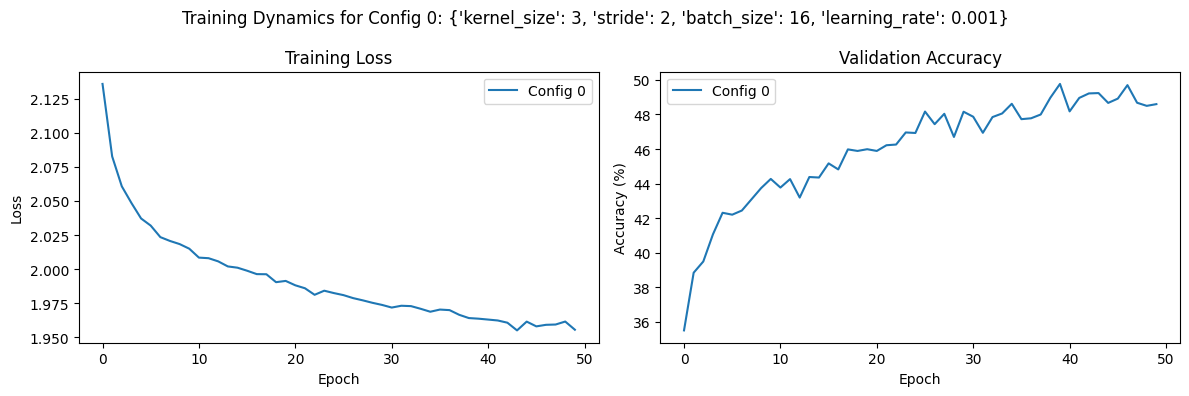

In [ ]:
plot_training_curves(configs, logs)